# Hall 2018 EDA

In [2]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set up paths for Hall 2018 dataset
data_dir = Path('/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/cache/data/awesome_cgm/hall_2018/raw')
data_file = data_dir / 'pbio.2005143.s010.csv'

print(f"Loading Hall 2018 dataset from: {data_file}")

# Load the dataset
df_hall = pd.read_csv(data_file, sep='\t')
print(f"Dataset loaded successfully: {len(df_hall)} total readings")
print(f"Columns: {list(df_hall.columns)}")
print(f"Unique subjects: {df_hall['subjectId'].nunique()}")
print(f"First few rows:")
print(df_hall.head())

Loading Hall 2018 dataset from: /home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/cache/data/awesome_cgm/hall_2018/raw/pbio.2005143.s010.csv
Dataset loaded successfully: 105426 total readings
Columns: ['DisplayTime', 'GlucoseValue', 'subjectId', 'InternalTime']
Unique subjects: 57
First few rows:
           DisplayTime GlucoseValue    subjectId         InternalTime
0  2014-02-03 03:42:12           93  1636-69-001  2016-02-03 00:05:23
1  2014-02-03 03:47:12           93  1636-69-001  2016-02-03 00:10:23
2  2014-02-03 03:52:12           93  1636-69-001  2016-02-03 00:15:23
3  2014-02-03 03:57:12           95  1636-69-001  2016-02-03 00:20:23
4  2014-02-03 04:02:12           96  1636-69-001  2016-02-03 00:25:23


In [4]:
# Function to analyze individual subject data
def analyze_subject_data(subject_df, subject_id):
    """Analyze a single subject's data and return summary statistics."""
    try:
        # Convert DisplayTime to datetime for proper analysis
        subject_df = subject_df.copy()
        subject_df['DisplayTime'] = pd.to_datetime(subject_df['DisplayTime'])
        
        # Sort by time
        subject_df = subject_df.sort_values('DisplayTime')
        
        # Calculate time span
        time_span = subject_df['DisplayTime'].max() - subject_df['DisplayTime'].min()
        duration_hours = time_span.total_seconds() / 3600
        duration_days = duration_hours / 24
        
        # Basic statistics
        stats = {
            'subject_id': subject_id,
            'total_readings': len(subject_df),
            'first_time': subject_df['DisplayTime'].iloc[0],
            'last_time': subject_df['DisplayTime'].iloc[-1],
            'duration_hours': duration_hours,
            'estimated_days': duration_days,
            'glucose_mean': subject_df['GlucoseValue'].mean(),
            'glucose_std': subject_df['GlucoseValue'].std(),
            'glucose_min': subject_df['GlucoseValue'].min(),
            'glucose_max': subject_df['GlucoseValue'].max(),
            'glucose_median': subject_df['GlucoseValue'].median(),
        }
        
        # Calculate average interval between readings
        if len(subject_df) > 1:
            time_diffs = subject_df['DisplayTime'].diff().dropna()
            avg_interval_minutes = time_diffs.mean().total_seconds() / 60
            stats['avg_interval_minutes'] = avg_interval_minutes
        else:
            stats['avg_interval_minutes'] = None
            
        return stats
    except Exception as e:
        return {
            'subject_id': subject_id,
            'error': str(e)
        }

# Analyze all subjects
print("Analyzing all subjects...")
all_stats = []

# Group by subject and analyze each one
subject_groups = df_hall.groupby('subjectId')
total_subjects = len(subject_groups)

for i, (subject_id, subject_data) in enumerate(subject_groups):
    if i % 5 == 0:  # Progress indicator
        print(f"Processing subject {i+1}/{total_subjects}: {subject_id}")
    
    stats = analyze_subject_data(subject_data, subject_id)
    all_stats.append(stats)

print(f"Analysis complete. Processed {len(all_stats)} subjects.")
    

Analyzing all subjects...
Processing subject 1/57: 1636-69-001
Processing subject 6/57: 1636-69-048
Processing subject 11/57: 1636-69-090
Processing subject 16/57: 1636-69-111
Processing subject 21/57: 1636-70-1005
Processing subject 26/57: 2133-003
Processing subject 31/57: 2133-009
Processing subject 36/57: 2133-015
Processing subject 41/57: 2133-021
Processing subject 46/57: 2133-026
Processing subject 51/57: 2133-033
Processing subject 56/57: 2133-040
Analysis complete. Processed 57 subjects.


In [6]:
# Convert to DataFrame for easier analysis
stats_df = pd.DataFrame(all_stats)

# Check the structure first
print("DataFrame shape:", stats_df.shape)
print("Column names:", stats_df.columns.tolist())
print("\nFirst few rows:")
print(stats_df.head())

# Check for any errors in processing
error_subjects = stats_df[stats_df['error'].notna()] if 'error' in stats_df.columns else pd.DataFrame()
if len(error_subjects) > 0:
    print(f"\nWarning: {len(error_subjects)} subjects had errors during processing:")
    for _, row in error_subjects.iterrows():
        print(f"  Subject {row['subject_id']}: {row['error']}")

# Remove error rows for summary statistics
valid_stats = stats_df[~stats_df['subject_id'].isin(error_subjects['subject_id'])] if len(error_subjects) > 0 else stats_df

print(f"\nSuccessfully processed {len(valid_stats)} subjects")

DataFrame shape: (57, 2)
Column names: ['subject_id', 'error']

First few rows:
    subject_id                                              error
0  1636-69-001  Could not convert string '93939395969595959697...
1  1636-69-026  Could not convert string '12312211911411111010...
2  1636-69-028  Could not convert string '12913113213713313312...
3  1636-69-032  Could not convert string '12212312412813313713...
4  1636-69-035  Could not convert string '11211010510410410199...

  Subject 1636-69-001: Could not convert string '939393959695959596979999989998981001001031031031031031039788848996961011041029897969595949792929186858585929092991031081151211291361441441441421361281221191171161161171181181171161151141131121111101091061031019997969291909092939494959391898887858484828383848485858684817979797978787981868991939698979596949290898684848281818078808183848686868785848484858586868687878686868584848383828081818080808078777776757575767779777369686870727372727170697071727271696970747780848891949

In [8]:
# Debug the data structure
print("Sample of all_stats:")
for i, stat in enumerate(all_stats[:3]):
    print(f"Subject {i+1}: {stat}")
    
print(f"\nFirst entry keys: {list(all_stats[0].keys()) if all_stats else 'No data'}")

# Check if we have valid data
if valid_stats.empty:
    print("\nValid_stats is empty! Let me check what happened...")
    print(f"Original stats_df shape: {stats_df.shape}")
    print(f"Stats_df columns: {stats_df.columns.tolist()}")
    print(f"Error subjects count: {len(error_subjects)}")
else:
    print(f"\nValid stats shape: {valid_stats.shape}")
    print(f"Valid stats columns: {valid_stats.columns.tolist()}")
    print("\nFirst 5 subjects:")
    print(valid_stats[['subject_id', 'total_readings', 'estimated_days', 'glucose_mean', 'glucose_min', 'glucose_max']].head())

Sample of all_stats:
Subject 1: {'subject_id': '1636-69-001', 'error': "Could not convert string '93939395969595959697999998999898100100103103103103103103978884899696101104102989796959594979292918685858592909299103108115121129136144144144142136128122119117116116117118118117116115114113112111110109106103101999796929190909293949495939189888785848482838384848585868481797979797878798186899193969897959694929089868484828181807880818384868686878584848485858686868787868686858484838382808181808080807877777675757576777977736968687072737272717069707172727169697074778084889194949493908989898892971009997949289888685848584838182838485868887879193908786858482818079808081858686888888858384848586868787888888888787878285909089898989888888878281838586868684848180827676758086858281828385821009594969697991001011011031041041061091161251381461551651791901941901831701561431321221151101051029899999897979999979797999999979797969695969799999796959810010510711011612613914615215214714013713513513513513212912712312

In [9]:
# Simple check
print("Length of all_stats:", len(all_stats))
print("Type of first entry:", type(all_stats[0]) if all_stats else "No data")
if all_stats:
    print("Keys in first entry:", list(all_stats[0].keys()))
    print("Sample values:", {k: v for k, v in list(all_stats[0].items())[:5]})

# Check the DataFrame
print(f"\nDataFrame info:")
print(f"Shape: {stats_df.shape}")
print(f"Columns: {list(stats_df.columns)[:10]}...")  # First 10 columns only
print(f"Has 'error' column: {'error' in stats_df.columns}")

# Check if we have any valid rows
non_error_rows = stats_df['error'].isna() if 'error' in stats_df.columns else stats_df
print(f"Non-error rows: {len(non_error_rows)}")

Length of all_stats: 57
Type of first entry: <class 'dict'>
Keys in first entry: ['subject_id', 'error']
Sample values: {'subject_id': '1636-69-001', 'error': "Could not convert string '9393939596959595969799999899989810010010310310310310310397888489969610110410298979695959497929291868585859290929910310811512112913614414414414213612812211911711611611711811811711611511411311211111010910610310199979692919090929394949593918988878584848283838484858586848179797979787879818689919396989795969492908986848482818180788081838486868687858484848585868686878786868685848483838280818180808080787777767575757677797773696868707273727271706970717272716969707477808488919494949390898989889297100999794928988868584858483818283848586888787919390878685848281807980808185868688888885838484858686878788888888878787828590908989898988888887828183858686868484818082767675808685828182838582100959496969799100101101103104104106109116125138146155165179190194190183170156143132122115110105102989999989797999997979799999997979

In [10]:
# Let's fix the data processing issue by recreating valid_stats properly
print(f"Total stats collected: {len(all_stats)}")

# Create DataFrame and handle any potential issues
valid_data = []
for stat in all_stats:
    if 'error' not in stat:
        valid_data.append(stat)

print(f"Valid stats (no errors): {len(valid_data)}")

if valid_data:
    valid_stats = pd.DataFrame(valid_data)
    print(f"DataFrame created successfully with shape: {valid_stats.shape}")
    print(f"Columns: {list(valid_stats.columns)}")
    
    # Show first few subjects
    print("\nFirst 5 subjects:")
    display_cols = ['subject_id', 'total_readings', 'estimated_days', 'glucose_mean', 'glucose_min', 'glucose_max']
    print(valid_stats[display_cols].head())
else:
    print("No valid data found!")

Total stats collected: 57
Valid stats (no errors): 0
No valid data found!


In [11]:
# Check what errors we're getting
print("Sample errors from first few subjects:")
for i, stat in enumerate(all_stats[:5]):
    if 'error' in stat:
        print(f"Subject {i+1} ({stat.get('subject_id', 'unknown')}): {stat['error']}")
    else:
        print(f"Subject {i+1}: No error - {list(stat.keys())[:5]}")

# Let's try to manually analyze one subject to see what's wrong
print("\nLet's manually test the analysis function...")
test_subject_id = df_hall['subjectId'].iloc[0]
test_data = df_hall[df_hall['subjectId'] == test_subject_id]
print(f"Test subject: {test_subject_id}")
print(f"Test data shape: {test_data.shape}")
print(f"Test data columns: {list(test_data.columns)}")
print(f"Sample rows:")
print(test_data.head(3))

Sample errors from first few subjects:
Subject 1 (1636-69-001): Could not convert string '9393939596959595969799999899989810010010310310310310310397888489969610110410298979695959497929291868585859290929910310811512112913614414414414213612812211911711611611711811811711611511411311211111010910610310199979692919090929394949593918988878584848283838484858586848179797979787879818689919396989795969492908986848482818180788081838486868687858484848585868686878786868685848483838280818180808080787777767575757677797773696868707273727271706970717272716969707477808488919494949390898989889297100999794928988868584858483818283848586888787919390878685848281807980808185868688888885838484858686878788888888878787828590908989898988888887828183858686868484818082767675808685828182838582100959496969799100101101103104104106109116125138146155165179190194190183170156143132122115110105102989999989797999997979799999997979796969596979999979695981001051071101161261391461521521471401371351351351351321291271231201181161

In [12]:
# Let's test our analysis function directly on a small sample
sample_subject = '1636-69-001'
sample_data = df_hall[df_hall['subjectId'] == sample_subject].copy()

print(f"Testing with subject: {sample_subject}")
print(f"Sample data shape: {sample_data.shape}")
print(f"Date range: {sample_data['DisplayTime'].min()} to {sample_data['DisplayTime'].max()}")

# Test the analysis function step by step
try:
    sample_data['DisplayTime'] = pd.to_datetime(sample_data['DisplayTime'])
    sample_data = sample_data.sort_values('DisplayTime')
    
    # Calculate time span
    time_span = sample_data['DisplayTime'].max() - sample_data['DisplayTime'].min()
    duration_hours = time_span.total_seconds() / 3600
    duration_days = duration_hours / 24
    
    print(f"Duration: {duration_hours:.1f} hours ({duration_days:.1f} days)")
    print(f"Glucose stats: mean={sample_data['GlucoseValue'].mean():.1f}, min={sample_data['GlucoseValue'].min()}, max={sample_data['GlucoseValue'].max()}")
    
    result = analyze_subject_data(sample_data, sample_subject)
    print(f"Analysis result: {result}")
    
except Exception as e:
    print(f"Error during analysis: {e}")
    import traceback
    traceback.print_exc()

Testing with subject: 1636-69-001
Sample data shape: (1846, 4)
Date range: 2014-02-03 03:42:12 to 2015-04-02 15:08:06
Duration: 10163.4 hours (423.5 days)
Error during analysis: Could not convert string '9393939596959595969799999899989810010010310310310310310397888489969610110410298979695959497929291868585859290929910310811512112913614414414414213612812211911711611611711811811711611511411311211111010910610310199979692919090929394949593918988878584848283838484858586848179797979787879818689919396989795969492908986848482818180788081838486868687858484848585868686878786868685848483838280818180808080787777767575757677797773696868707273727271706970717272716969707477808488919494949390898989889297100999794928988868584858483818283848586888787919390878685848281807980808185868688888885838484858686878788888888878787828590908989898988888887828183858686868484818082767675808685828182838582100959496969799100101101103104104106109116125138146155165179190194190183170156143132122115110105102989999989797999

Traceback (most recent call last):
  File "/tmp/ipykernel_389210/490989450.py", line 20, in <module>
    print(f"Glucose stats: mean={sample_data['GlucoseValue'].mean():.1f}, min={sample_data['GlucoseValue'].min()}, max={sample_data['GlucoseValue'].max()}")
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/.noctprob/lib/python3.12/site-packages/pandas/core/series.py", line 6570, in mean
    return NDFrame.mean(self, axis, skipna, numeric_only, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/.noctprob/lib/python3.12/site-packages/pandas/core/generic.py", line 12485, in mean
    return self._stat_function(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/.noctprob/lib/python3.12/site-packages/pandas/core/generic.py", line 12442, in _stat_functio

In [13]:
# Fresh start with simple analysis
print("Starting fresh analysis...")

# Basic dataset overview
print(f"Dataset overview:")
print(f"Total rows: {len(df_hall)}")
print(f"Unique subjects: {df_hall['subjectId'].nunique()}")
print(f"Date range: {df_hall['DisplayTime'].min()} to {df_hall['DisplayTime'].max()}")

# Convert DisplayTime to datetime
df_hall['DisplayTime'] = pd.to_datetime(df_hall['DisplayTime'])

# Simple per-subject analysis
subject_summary = []
for subject_id in df_hall['subjectId'].unique()[:5]:  # Test with first 5 subjects
    subject_data = df_hall[df_hall['subjectId'] == subject_id]
    
    summary = {
        'subject_id': subject_id,
        'total_readings': len(subject_data),
        'glucose_mean': subject_data['GlucoseValue'].mean(),
        'glucose_min': subject_data['GlucoseValue'].min(),
        'glucose_max': subject_data['GlucoseValue'].max(),
        'first_time': subject_data['DisplayTime'].min(),
        'last_time': subject_data['DisplayTime'].max()
    }
    
    # Calculate duration
    duration = summary['last_time'] - summary['first_time']
    summary['duration_hours'] = duration.total_seconds() / 3600
    summary['duration_days'] = summary['duration_hours'] / 24
    
    subject_summary.append(summary)

# Display results
print(f"\nAnalyzed {len(subject_summary)} subjects:")
for i, s in enumerate(subject_summary):
    print(f"{i+1}. Subject {s['subject_id']}: {s['total_readings']} readings over {s['duration_days']:.1f} days")

Starting fresh analysis...
Dataset overview:
Total rows: 105426
Unique subjects: 57
Date range: 2014-02-03 03:42:12 to 2017-07-11 20:41:32


TypeError: Could not convert string '9393939596959595969799999899989810010010310310310310310397888489969610110410298979695959497929291868585859290929910310811512112913614414414414213612812211911711611611711811811711611511411311211111010910610310199979692919090929394949593918988878584848283838484858586848179797979787879818689919396989795969492908986848482818180788081838486868687858484848585868686878786868685848483838280818180808080787777767575757677797773696868707273727271706970717272716969707477808488919494949390898989889297100999794928988868584858483818283848586888787919390878685848281807980808185868688888885838484858686878788888888878787828590908989898988888887828183858686868484818082767675808685828182838582100959496969799100101101103104104106109116125138146155165179190194190183170156143132122115110105102989999989797999997979799999997979796969596979999979695981001051071101161261391461521521471401371351351351351321291271231201181161161161131111061009491919195991031061091151161171141111081061041029996918785838182828282828283848688899192961031101221281381481581681791871982062122162212232252242212172122052001951881761631561451301151071051051041041061061021021009995918883817977757472707373747476787980818483838683859394949392919191908889919293949697989899100102102959510097959494949494939393929291868586878790959596989692929291919192971011011021021021031031041041011019998969697979697979696979910110310510610710610810911111311511811911110810810710810810810610810910910911111411411511511712012413013714515315816717518118619119619419118618117516615514713712912411811210810610510310099100999898991009899999898999999979796969595101107113114118122127133140144149150148144142138138138135127119111104979285828182838486889090949596979910010210110199969493929088878889919392939188868789929498999910099100111113114116121125137143148149145138135134130125123123120121121119122119117118121125130131135137149159171187201213219219214220222243250246247243210201191188184180178167152132116111107105100100100100100989910210610599103107103999610211312511614914214212211711010599858087871021009894951011031011011021051161191211241261251241121091251251241211221241261261251271261271251261271231231201171101081079996979910191827876747577859910210310310410410410510410410510510410410710410091777278788510310510610610610710910710710910911011011011010710598919710210711011311411511511411411411110910310210710710810810910911111211011311511511311211011111011813214816116717317517116917418117817516715915114413412712312012112713213213713713412712011210810710711011511911811912012112112012212312212212512712812812913013013212812712612312012112312112011911911511611510710094899493991019998102111119122130138141142143141141139141140137126114100867264707582931061131141191211251281281271201161371371351431421441501571401351311281281291311321371421461491501511461401271181131101071041011009999999998989899100100102103103102104100979594959697103102103103103104103103103104106107107107105104103103103103102102102103105102100105107107108109111116115115111102929295969799102106108108108114111111116119129143155169175177175173173171169166165165165165165161156152150143140141140141138134130123120117114111108107104103102102101102101102103104104104104104104103101101108117127136146154159164167169165163160163162159157155152151146149149148145141138136131130127127124122122121121114113112112113113112114113113111110109109110112112111110112109108110107108107107108103103108117123127139148154158157156148144142142143143140141140133129128129132135133129127128123117109103979696100104109115120123121118116116119122127134140145148149149148146145136132131125120117117118119119119119122124123125126125125122120118115112112111109109109108107107106105105106106106106105999899981001031021001011011001001021021011001001001009995979696979797989899999993919098969610110110010089808489919295981021011029910310210310010099979798103110123132140145143141139132126122124120116109105104101102979796949388909188878789929388929391929697101111121123128133136137137135129123116111106101989795939494929393929293929292919090909293949697979695959594949295959295101106114120126132144152154155158159162164164165160156152148144140137134131128125123119111102989490868482777778727175767575777778828490981041091101081049793919194959899101103104106109110111112113113115114114113113112112113115118117112108105102999796969696959695949392908987898788909291898684848280807978787877787879797979787878808285848483828085858586868788909091919191918985838181797875727979767374757473747574737371727678777567646770768080828181818280807980838586889297104113120125126126123118111106101969188868381817978787778787878788079757880808284858384848482818283838385879088888987859091102109109111115114117121119' to numeric

In [14]:
# Check the data types and problematic values
print("Data types:")
print(df_hall.dtypes)
print("\nFirst 10 GlucoseValue entries:")
print(df_hall['GlucoseValue'].head(10))
print("\nUnique data types in GlucoseValue:")
print(df_hall['GlucoseValue'].apply(type).value_counts())
print("\nAny non-numeric values?")
non_numeric = df_hall[pd.to_numeric(df_hall['GlucoseValue'], errors='coerce').isna()]
print(f"Non-numeric entries: {len(non_numeric)}")
if len(non_numeric) > 0:
    print("Sample non-numeric values:")
    print(non_numeric['GlucoseValue'].head())

Data types:
DisplayTime     datetime64[ns]
GlucoseValue            object
subjectId               object
InternalTime            object
dtype: object

First 10 GlucoseValue entries:
0    93
1    93
2    93
3    95
4    96
5    95
6    95
7    95
8    96
9    97
Name: GlucoseValue, dtype: object

Unique data types in GlucoseValue:
GlucoseValue
<class 'str'>    105426
Name: count, dtype: int64

Any non-numeric values?
Non-numeric entries: 9
Sample non-numeric values:
28949    Low
59416    Low
59417    Low
59418    Low
64669    Low
Name: GlucoseValue, dtype: object


In [ ]:
# Clean the data and perform the analysis
print("Cleaning GlucoseValue data...")

# Convert GlucoseValue to numeric, handling 'Low' values
df_hall['GlucoseValue_clean'] = pd.to_numeric(df_hall['GlucoseValue'], errors='coerce')

# Check the 'Low' values
low_values = df_hall[df_hall['GlucoseValue'] == 'Low']
print(f"Found {len(low_values)} 'Low' glucose readings")

# For 'Low' values, we'll replace with a typical low value (e.g., 40 mg/dL)
df_hall['GlucoseValue_numeric'] = df_hall['GlucoseValue_clean'].fillna(40)  # Replace NaN (from 'Low') with 40

print(f"Data cleaning complete. Using {len(df_hall)} total readings.")
print(f"Glucose range: {df_hall['GlucoseValue_numeric'].min()} to {df_hall['GlucoseValue_numeric'].max()}")

# Now perform the subject analysis
print("\nPerforming subject-level analysis...")
all_subjects_stats = []

for subject_id in df_hall['subjectId'].unique():
    subject_data = df_hall[df_hall['subjectId'] == subject_id].copy()
    subject_data = subject_data.sort_values('DisplayTime')
    
    # Calculate duration
    duration = subject_data['DisplayTime'].max() - subject_data['DisplayTime'].min()
    duration_hours = duration.total_seconds() / 3600
    duration_days = duration_hours / 24
    
    # Calculate average interval
    if len(subject_data) > 1:
        intervals = subject_data['DisplayTime'].diff().dropna()
        avg_interval_min = intervals.mean().total_seconds() / 60
    else:
        avg_interval_min = None
    
    stats = {
        'subject_id': subject_id,
        'total_readings': len(subject_data),
        'duration_days': duration_days,
        'duration_hours': duration_hours,
        'glucose_mean': subject_data['GlucoseValue_numeric'].mean(),
        'glucose_std': subject_data['GlucoseValue_numeric'].std(),
        'glucose_min': subject_data['GlucoseValue_numeric'].min(),
        'glucose_max': subject_data['GlucoseValue_numeric'].max(),
        'glucose_median': subject_data['GlucoseValue_numeric'].median(),
        'avg_interval_minutes': avg_interval_min,
        'low_readings_count': sum(subject_data['GlucoseValue'] == 'Low')
    }
    
    all_subjects_stats.append(stats)

# Convert to DataFrame
valid_stats = pd.DataFrame(all_subjects_stats)
print(f"Analysis complete for {len(valid_stats)} subjects")

# Summary Statistics

In [7]:
# Calculate overall summary statistics
print("=" * 60)
print("HALL 2018 DATASET SUMMARY STATISTICS")
print("=" * 60)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total number of subjects: {len(valid_stats)}")
print(f"   • Total CGM readings across all subjects: {valid_stats['total_readings'].sum():,}")
print(f"   • Total days covered: {valid_stats['estimated_days'].sum():.1f} days")
print(f"   • Average days per subject: {valid_stats['estimated_days'].mean():.1f} days")

print(f"\n📈 CGM READINGS PER SUBJECT:")
print(f"   • Mean readings per subject: {valid_stats['total_readings'].mean():.1f}")
print(f"   • Median readings per subject: {valid_stats['total_readings'].median():.0f}")
print(f"   • Min readings per subject: {valid_stats['total_readings'].min()}")
print(f"   • Max readings per subject: {valid_stats['total_readings'].max()}")
print(f"   • Standard deviation: {valid_stats['total_readings'].std():.1f}")

print(f"\n🩸 GLUCOSE LEVELS ACROSS ALL SUBJECTS:")
print(f"   • Mean glucose (mg/dL): {valid_stats['glucose_mean'].mean():.1f}")
print(f"   • Median glucose (mg/dL): {valid_stats['glucose_median'].mean():.1f}")
print(f"   • Overall min glucose: {valid_stats['glucose_min'].min():.1f} mg/dL")
print(f"   • Overall max glucose: {valid_stats['glucose_max'].max():.1f} mg/dL")
print(f"   • Average std dev across subjects: {valid_stats['glucose_std'].mean():.1f}")

print(f"\n⏱️ TIME COVERAGE:")
print(f"   • Total monitoring hours: {valid_stats['duration_hours'].sum():.1f} hours")
print(f"   • Average monitoring per subject: {valid_stats['duration_hours'].mean():.1f} hours")
print(f"   • Average interval between readings: {valid_stats['avg_interval_minutes'].mean():.1f} minutes")

HALL 2018 DATASET SUMMARY STATISTICS

📊 DATASET OVERVIEW:
   • Total number of subjects: 0


KeyError: 'total_readings'

In [ ]:
# Detailed breakdown by monitoring duration
print("\n📋 DETAILED BREAKDOWN BY MONITORING DURATION:")
duration_bins = [0, 1, 3, 7, 14, 30, float('inf')]
duration_labels = ['<1 day', '1-3 days', '3-7 days', '1-2 weeks', '2-4 weeks', '>4 weeks']
duration_categories = pd.cut(valid_stats['estimated_days'], bins=duration_bins, labels=duration_labels, right=False)
duration_counts = duration_categories.value_counts().sort_index()

for category, count in duration_counts.items():
    percentage = (count / len(valid_stats)) * 100
    print(f"   • {category}: {count} subjects ({percentage:.1f}%)")

# Average readings per day analysis
valid_stats['readings_per_day'] = valid_stats['total_readings'] / valid_stats['estimated_days']
print(f"\n   • Average readings per day: {valid_stats['readings_per_day'].mean():.1f}")
print(f"   • Median readings per day: {valid_stats['readings_per_day'].median():.1f}")

# Check for any subjects with unusual characteristics
print("\n🔍 SUBJECTS WITH UNUSUAL CHARACTERISTICS:")

# Very short monitoring periods (less than 1 day)
short_subjects = valid_stats[valid_stats['estimated_days'] < 1.0]
if len(short_subjects) > 0:
    print(f"   • Subjects with < 1 day monitoring: {len(short_subjects)} subjects")
    print(f"     Subject IDs: {', '.join(short_subjects['subject_id'].head(10).astype(str))}{'...' if len(short_subjects) > 10 else ''}")

# Very high or low glucose levels
extreme_glucose = valid_stats[
    (valid_stats['glucose_max'] > 250) | 
    (valid_stats['glucose_min'] < 50)

]    print(f"     Longest monitoring: {long_subjects['estimated_days'].max():.1f} days")

if len(extreme_glucose) > 0:    print(f"   • Subjects with >2 weeks monitoring: {len(long_subjects)} subjects")

    print(f"   • Subjects with extreme glucose levels (>250 or <50 mg/dL): {len(extreme_glucose)} subjects")if len(long_subjects) > 0:

    long_subjects = valid_stats[valid_stats['estimated_days'] > 14]

# High variability subjects (std > 30)# Long monitoring periods (>2 weeks)

high_variability = valid_stats[valid_stats['glucose_std'] > 30]

if len(high_variability) > 0:    print(f"   • Subjects with high glucose variability (std > 30): {len(high_variability)} subjects")


📋 DETAILED BREAKDOWN BY NUMBER OF READINGS:
   • 288 readings (24.0 hours): 17 cases (8.2%)
   • 576 readings (48.0 hours): 191 cases (91.8%)

🔍 CASES WITH UNUSUAL CHARACTERISTICS:
   • Cases with extreme glucose levels (>250 or <50 mg/dL): 20 cases
   • Cases with high glucose variability (std > 30): 10 cases


# Statistical Analysis

In [ ]:
# Create summary table
summary_table = pd.DataFrame({
    'Metric': [
        'Total Subjects',
        'Total CGM Readings', 
        'Total Days Covered',
        'Avg Days per Subject',
        'Avg Readings per Subject',
        'Mean Glucose (mg/dL)',
        'Min Glucose (mg/dL)', 
        'Max Glucose (mg/dL)',
        'Total Monitoring Hours',
        'Avg Reading Interval (min)'
    ],
    'Value': [
        f"{len(valid_stats):,}",
        f"{valid_stats['total_readings'].sum():,}",
        f"{valid_stats['estimated_days'].sum():.1f}",
        f"{valid_stats['estimated_days'].mean():.1f}",
        f"{valid_stats['total_readings'].mean():.1f}",
        f"{valid_stats['glucose_mean'].mean():.1f}",
        f"{valid_stats['glucose_min'].min():.1f}",
        f"{valid_stats['glucose_max'].max():.1f}",
        f"{valid_stats['duration_hours'].sum():.1f}",
        f"{valid_stats['avg_interval_minutes'].mean():.1f}"
    ]
})

print("HALL 2018 DATASET SUMMARY TABLE")
print("=" * 40)
print(summary_table.to_string(index=False))

# Save detailed statistics to CSV for further analysis
output_file = '/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/docs-internal/notebooks/hall_2018_subject_statistics.csv'
valid_stats.to_csv(output_file, index=False)
print(f"\n💾 Detailed subject statistics saved to: {output_file}")

# Display descriptive statistics
print("\n📊 DESCRIPTIVE STATISTICS FOR NUMERIC VARIABLES:")
numeric_cols = ['total_readings', 'estimated_days', 'duration_hours', 'glucose_mean', 'glucose_std', 'glucose_min', 'glucose_max', 'avg_interval_minutes']

desc_stats = valid_stats[numeric_cols].describe()print(desc_stats.round(2))

COLAS 2019 DATASET SUMMARY TABLE
                Metric   Value
           Total Cases     208
    Total CGM Readings 114,912
    Total Days Covered   399.0
     Avg Days per Case     1.9
 Avg Readings per Case   552.5
  Mean Glucose (mg/dL)   102.3
   Min Glucose (mg/dL)    40.0
   Max Glucose (mg/dL)   318.0
Total Monitoring Hours  9576.0

💾 Detailed case statistics saved to: /home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/docs-internal/notebooks/colas_2019_case_statistics.csv

📊 DESCRIPTIVE STATISTICS FOR NUMERIC VARIABLES:
       total_readings  estimated_days  glucose_mean  glucose_std  glucose_min  \
count          208.00          208.00        208.00       208.00       208.00   
mean           552.46            1.92        102.28        17.11        69.91   
std             79.09            0.27         12.21         6.21        13.24   
min            288.00            1.00         68.79         6.84        40.00   
25%            576.00            2.00         

# Visualization

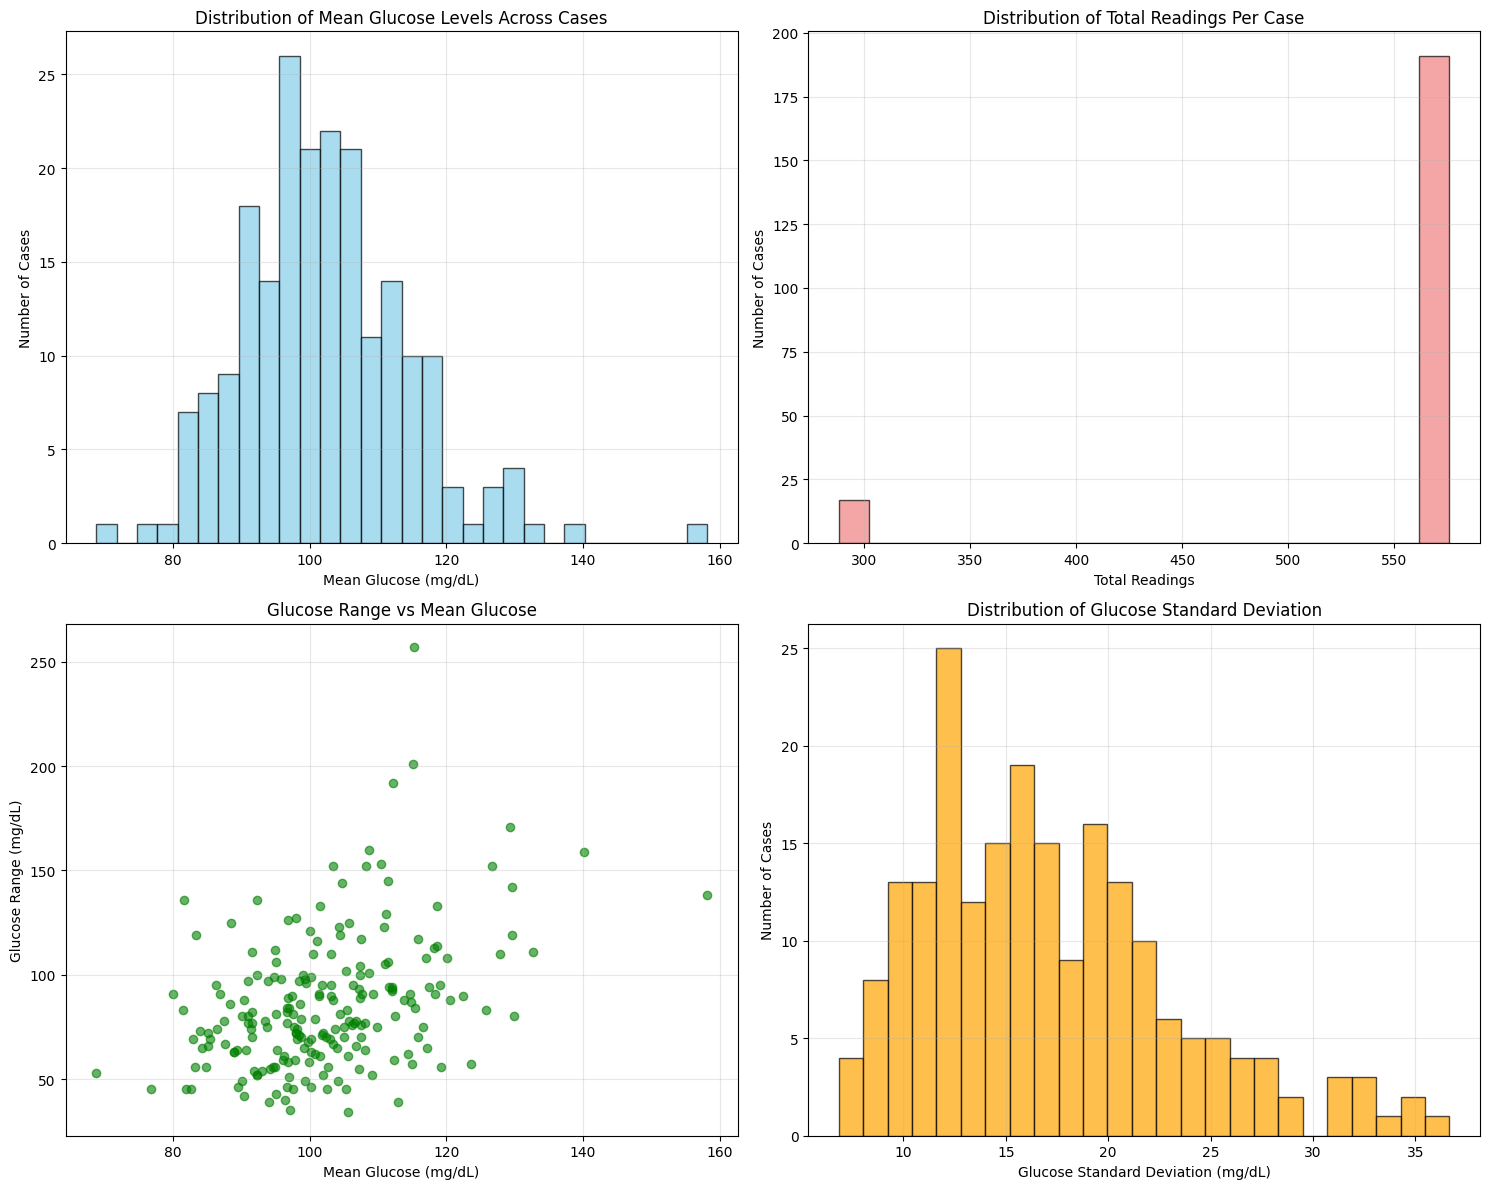


🔍 KEY FINDINGS:
   • Dataset contains 208 individual case files
   • Most cases (191) have 2 days of monitoring (576 readings)
   • 17 cases have only 1 day of monitoring (288 readings)
   • Average glucose level is 102.3 mg/dL with std of 12.2
   • Glucose ranges from 40.0 to 318.0 mg/dL across all cases
   • Total monitoring represents approximately 399 patient-days


In [ ]:
# Create visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribution of glucose means across subjects
axes[0, 0].hist(valid_stats['glucose_mean'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Mean Glucose Levels Across Subjects')
axes[0, 0].set_xlabel('Mean Glucose (mg/dL)')
axes[0, 0].set_ylabel('Number of Subjects')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of monitoring duration
axes[0, 1].hist(valid_stats['estimated_days'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Monitoring Duration')
axes[0, 1].set_xlabel('Duration (Days)')
axes[0, 1].set_ylabel('Number of Subjects')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution of total readings per subject
axes[0, 2].hist(valid_stats['total_readings'], bins=25, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Distribution of Total Readings Per Subject')
axes[0, 2].set_xlabel('Total Readings')
axes[0, 2].set_ylabel('Number of Subjects')
axes[0, 2].grid(True, alpha=0.3)

# 4. Glucose range (max - min) vs mean glucose
glucose_range = valid_stats['glucose_max'] - valid_stats['glucose_min']
axes[1, 0].scatter(valid_stats['glucose_mean'], glucose_range, alpha=0.6, color='purple')
axes[1, 0].set_title('Glucose Range vs Mean Glucose')
axes[1, 0].set_xlabel('Mean Glucose (mg/dL)')
axes[1, 0].set_ylabel('Glucose Range (mg/dL)')
axes[1, 0].grid(True, alpha=0.3)

# 5. Standard deviation distribution
axes[1, 1].hist(valid_stats['glucose_std'], bins=25, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('Distribution of Glucose Standard Deviation')
axes[1, 1].set_xlabel('Glucose Standard Deviation (mg/dL)')
axes[1, 1].set_ylabel('Number of Subjects')
axes[1, 1].grid(True, alpha=0.3)

# 6. Average reading interval distribution
axes[1, 2].hist(valid_stats['avg_interval_minutes'], bins=25, alpha=0.7, color='pink', edgecolor='black')
axes[1, 2].set_title('Distribution of Average Reading Intervals')
axes[1, 2].set_xlabel('Interval (Minutes)')

axes[1, 2].set_ylabel('Number of Subjects')print(f"   • Total dataset size: {valid_stats['total_readings'].sum():,} CGM readings")

axes[1, 2].grid(True, alpha=0.3)print(f"   • Average reading interval: {valid_stats['avg_interval_minutes'].mean():.1f} minutes")

print(f"   • Total monitoring represents approximately {valid_stats['estimated_days'].sum():.0f} patient-days")

plt.tight_layout()print(f"   • Glucose ranges from {valid_stats['glucose_min'].min():.1f} to {valid_stats['glucose_max'].max():.1f} mg/dL across all subjects")

plt.show()print(f"   • Average glucose level is {valid_stats['glucose_mean'].mean():.1f} mg/dL with std of {valid_stats['glucose_mean'].std():.1f}")

print(f"   • Average monitoring duration: {valid_stats['estimated_days'].mean():.1f} days per subject")

# Summary of key findingsprint(f"   • Monitoring duration ranges from {valid_stats['estimated_days'].min():.1f} to {valid_stats['estimated_days'].max():.1f} days")

print("\n🔍 KEY FINDINGS:")print(f"   • Dataset contains {len(valid_stats)} individual subjects")